In [90]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Load training and testing datasets
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

# Extract features and target from datasets
X_train = df_train[df_train.columns[4:]].values
y_train = df_train[df_train.columns[2]].values
X_test = df_test[df_test.columns[4:]].values
y_test = df_test[df_test.columns[2]].values

# Track the number of samples per date for the rolling window
date_counts = np.hstack([df_train.groupby('date').size(), df_test.groupby('date').size()])

# Extract stocks and dates from the test dataset
stocks = df_test["stock_id"].values
dates = df_test["date"].values
unique_test_dates = np.unique(dates)

# Initialize the Linear Regression model
model = LinearRegression()

# List to store predictions
predictions = []

# Loop through each test date to apply the rolling window
for idx, current_date in enumerate(unique_test_dates):
    
    # Filter the test data for the current date
    test_idx = dates == current_date
    X_test_month = X_test[test_idx]
    y_test_month = y_test[test_idx]
    stocks_month = stocks[test_idx]

    # Train the model on the current training data
    model.fit(X_train, y_train)

    # Predict for the current test month
    month_predictions = model.predict(X_test_month)

    # Store predictions
    for stock, actual, pred in zip(stocks_month, y_test_month, month_predictions):
        predictions.append({
            "Date": current_date,
            "Stock": stock,
            "Actual": actual,
            "Prediction": pred
        })

    # Update training set: Remove the oldest date and add the current test month
    X_train = np.vstack([X_train[date_counts[idx]:], X_test_month])
    y_train = np.append(y_train[date_counts[idx]:], y_test_month)

# Create predictions DataFrame and evaluate
predictions_df = pd.DataFrame(predictions)
predictions_df["Error"] = (predictions_df["Actual"] - predictions_df["Prediction"]).abs()
average_mae = predictions_df.groupby("Date")["Error"].mean()
print(f"Average MAE per month:\n{average_mae}")

# Save predictions to CSV
predictions_df.to_csv("predictions_LinearReg.csv", index=False)


Average MAE per month:
Date
2008-01-31    0.084292
2008-02-29    0.071355
2008-03-31    0.091628
2008-04-30    0.074873
2008-05-31    0.131283
                ...   
2018-07-31    0.085563
2018-08-31    0.053357
2018-09-30    0.107888
2018-10-31    0.074709
2018-11-30    0.136459
Name: Error, Length: 131, dtype: float64


In [91]:
predictions_df = pd.read_csv("predictions_LinearReg.csv")
predictions_df

,Date,Stock,Actual,Prediction,Error
0,2008-01-31,228,0.081,0.019133,0.061867
1,2008-01-31,342,-0.011,0.008343,0.019343
2,2008-01-31,349,0.058,0.010856,0.047144
3,2008-01-31,465,0.095,0.001564,0.093436
4,2008-01-31,587,-0.055,0.014519,0.069519
...,...,...,...,...,...
155170,2018-11-30,414,-0.084,0.010239,0.094239
155171,2018-11-30,665,-0.085,-0.001344,0.083656
155172,2018-11-30,943,-0.117,0.004436,0.121436
155173,2018-11-30,950,-0.196,0.024738,0.220738


In [92]:
# Create 'LongShort' column
predictions_df['LongShort'] = np.where(predictions_df['Prediction'] > 0, 
                                        predictions_df['Actual'], 
                                        -predictions_df['Actual'])

# Create 'AbsPrediction' and 'NormalizedWeight'
predictions_df['AbsPrediction'] = predictions_df['Prediction'].abs()
predictions_df['NormalizedWeight'] = predictions_df.groupby('Date')['AbsPrediction'].transform(lambda x: x / x.sum())

# Create 'LongShortWeighted'
predictions_df["LongShortWeighted"] = predictions_df["LongShort"] * predictions_df["NormalizedWeight"]

# Display updated DataFrame
predictions_df

,Date,Stock,Actual,Prediction,Error,LongShort,AbsPrediction,NormalizedWeight,LongShortWeighted
0,2008-01-31,228,0.081,0.019133,0.061867,0.081,0.019133,0.001002,0.000081
1,2008-01-31,342,-0.011,0.008343,0.019343,-0.011,0.008343,0.000437,-0.000005
2,2008-01-31,349,0.058,0.010856,0.047144,0.058,0.010856,0.000568,0.000033
3,2008-01-31,465,0.095,0.001564,0.093436,0.095,0.001564,0.000082,0.000008
4,2008-01-31,587,-0.055,0.014519,0.069519,-0.055,0.014519,0.000760,-0.000042
...,...,...,...,...,...,...,...,...,...
155170,2018-11-30,414,-0.084,0.010239,0.094239,-0.084,0.010239,0.000740,-0.000062
155171,2018-11-30,665,-0.085,-0.001344,0.083656,0.085,0.001344,0.000097,0.000008
155172,2018-11-30,943,-0.117,0.004436,0.121436,-0.117,0.004436,0.000321,-0.000038
155173,2018-11-30,950,-0.196,0.024738,0.220738,-0.196,0.024738,0.001789,-0.000351


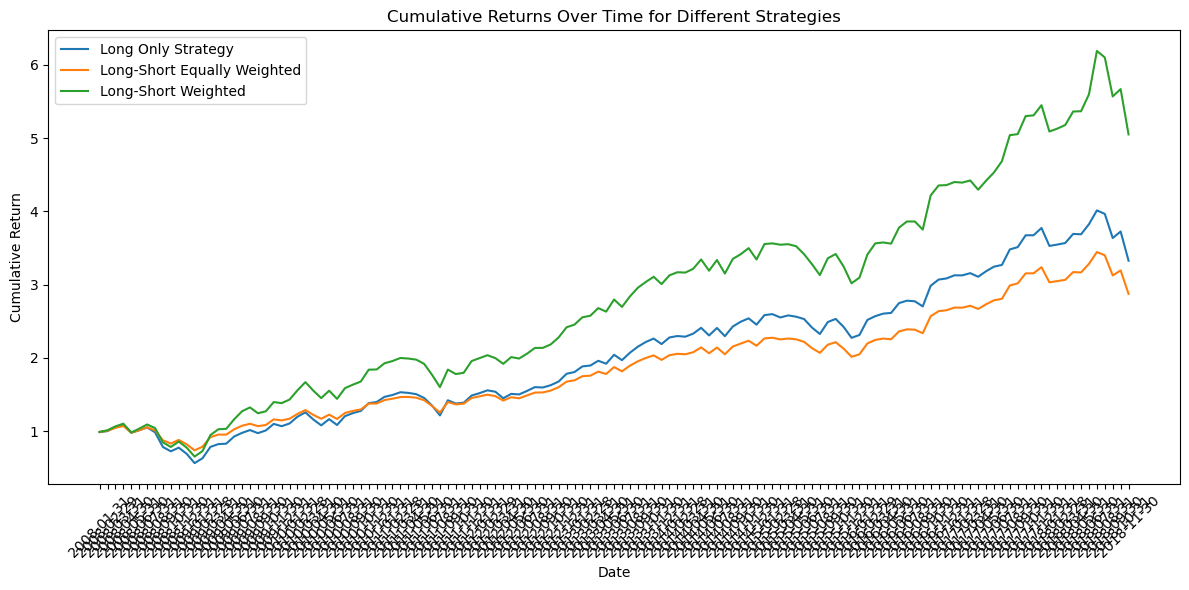

In [93]:
# Step 1: Group by Date and calculate cumulative returns for each strategy
cumulative_returns = predictions_df.groupby('Date').agg({
    'Actual': 'mean',  # Long-only strategy (mean actual return for each date)
    'LongShort': 'mean',  # Long-Short Equally Weighted (mean for each date)
    'LongShortWeighted': 'sum'  # Long-Short Weighted (sum of weights for each date)
}).reset_index()

# Compute cumulative returns
cumulative_returns['LongOnlyCumulative'] = (1 + cumulative_returns['Actual']).cumprod()
cumulative_returns['LongShortCumulative'] = (1 + cumulative_returns['LongShort']).cumprod()
cumulative_returns['LongShortWeightedCumulative'] = (1 + cumulative_returns['LongShortWeighted']).cumprod()

# Step 2: Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns['Date'], cumulative_returns['LongOnlyCumulative'], label='Long Only Strategy')
plt.plot(cumulative_returns['Date'], cumulative_returns['LongShortCumulative'], label='Long-Short Equally Weighted')
plt.plot(cumulative_returns['Date'], cumulative_returns['LongShortWeightedCumulative'], label='Long-Short Weighted')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns Over Time for Different Strategies')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [94]:
def annualized_return(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].mean().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the cumulative product to get total growth over the period
    cumulative_product = (1 + monthly_returns['monthly_return']).prod()
    
    # Annualize the return: 
    annualized_return = cumulative_product ** (12 / len(monthly_returns)) - 1
    
    return annualized_return

def annualized_return_preweighted(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].sum().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the cumulative product to get total portfolio growth
    cumulative_product = (1 + monthly_returns['monthly_return']).prod()
    
    # Annualize the return: 
    annualized_return = cumulative_product ** (12 / len(monthly_returns)) - 1
    
    return annualized_return

def annualized_volatility(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].mean().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the monthly standard deviation (volatility)
    monthly_volatility = monthly_returns['monthly_return'].std()
    
    # Annualize the volatility
    annualized_volatility = monthly_volatility * np.sqrt(12)
    
    return annualized_volatility

def annualized_volatility_preweighted(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].sum().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the monthly standard deviation (volatility)
    monthly_volatility = monthly_returns['monthly_return'].std()
    
    # Annualize the volatility
    annualized_volatility = monthly_volatility * np.sqrt(12)
    
    return annualized_volatility

def annualized_sharpe_ratio(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].mean().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the average monthly return
    average_monthly_return = monthly_returns['monthly_return'].mean()
    
    # Calculate the standard deviation (volatility) of the monthly returns
    monthly_volatility = monthly_returns['monthly_return'].std()

    # Sharpe ratio calculation
    sharpe_ratio = average_monthly_return / monthly_volatility

    # Annualize the Sharpe ratio
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(12)
    
    return annualized_sharpe_ratio

def annualized_sharpe_ratio_preweighted(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].sum().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the average monthly return
    average_monthly_return = monthly_returns['monthly_return'].mean()
    
    # Calculate the standard deviation (volatility) of the monthly returns
    monthly_volatility = monthly_returns['monthly_return'].std()

    # Sharpe ratio calculation
    sharpe_ratio = average_monthly_return / monthly_volatility

    # Annualize the Sharpe ratio
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(12)
    
    return annualized_sharpe_ratio

def maximum_drawdown(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].mean().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the cumulative return
    monthly_returns['cumulative_return'] = (1 + monthly_returns['monthly_return']).cumprod()
    
    # Calculate the running maximum of the cumulative return
    monthly_returns['running_max'] = monthly_returns['cumulative_return'].cummax()
    
    # Calculate the drawdown
    monthly_returns['drawdown'] = (monthly_returns['cumulative_return'] - monthly_returns['running_max']) / monthly_returns['running_max']
    
    # Find the maximum drawdown
    max_drawdown = monthly_returns['drawdown'].min()
    
    return max_drawdown

def maximum_drawdown_preweighted(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].sum().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Calculate the cumulative return
    monthly_returns['cumulative_return'] = (1 + monthly_returns['monthly_return']).cumprod()
    
    # Calculate the running maximum of the cumulative return
    monthly_returns['running_max'] = monthly_returns['cumulative_return'].cummax()
    
    # Calculate the drawdown
    monthly_returns['drawdown'] = (monthly_returns['cumulative_return'] - monthly_returns['running_max']) / monthly_returns['running_max']
    
    # Find the maximum drawdown
    max_drawdown = monthly_returns['drawdown'].min()
    
    return max_drawdown

def worst_month(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].mean().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Find the worst month
    worst_month = monthly_returns['monthly_return'].min()
    
    return worst_month

def worst_month_preweighted(df, column_name):
    # Calculate monthly returns
    monthly_returns = df.groupby('Date')[column_name].sum().reset_index()
    monthly_returns.columns = ['date', 'monthly_return']
    
    # Find the worst month
    worst_month = monthly_returns['monthly_return'].min()
    
    return worst_month


In [95]:
print("Long Only Returns: ", annualized_return(predictions_df, "Actual"))
print("LongShort Equally Weighted Returns: ", annualized_return(predictions_df, "LongShort"))
print("LongShort Weighted Returns: ", annualized_return_preweighted(predictions_df, "LongShortWeighted"))

Long Only Returns:  0.11638228719192933
LongShort Equally Weighted Returns:  0.10149906050320867
LongShort Weighted Returns:  0.15990260657447264


In [96]:
print("Long Only Volatility: ", annualized_volatility(predictions_df, "Actual"))
print("LongShort Equally Weighted Volatility: ", annualized_volatility(predictions_df, "LongShort"))
print("LongShort Weighted Volatility: ", annualized_volatility_preweighted(predictions_df, "LongShortWeighted"))

Long Only Volatility:  0.2019928270137038
LongShort Equally Weighted Volatility:  0.14828473758319177
LongShort Weighted Volatility:  0.2131902486641054


In [97]:
print("Long Only Sharpe: ", annualized_sharpe_ratio(predictions_df, "Actual"))
print("LongShort Equally Weighted Sharpe: ", annualized_sharpe_ratio(predictions_df, "LongShort"))
print("LongShort Weighted Sharpe: ", annualized_sharpe_ratio_preweighted(predictions_df, "LongShortWeighted"))

Long Only Sharpe:  0.6483765787498285
LongShort Equally Weighted Sharpe:  0.7282262233842226
LongShort Weighted Sharpe:  0.8042483014548871


In [98]:
print("Long Only Max Drawdown: ", maximum_drawdown(predictions_df, "Actual"))
print("LongShort Equally Weighted Max Drawdown: ", maximum_drawdown(predictions_df, "LongShort"))
print("LongShort Weighted Max Drawdown: ", maximum_drawdown_preweighted(predictions_df, "LongShortWeighted"))

Long Only Max Drawdown:  -0.4842706473002366
LongShort Equally Weighted Max Drawdown:  -0.31035443601973023
LongShort Weighted Max Drawdown:  -0.40747986300858785


In [99]:
print("Long Only Worst Month: ", worst_month(predictions_df, "Actual"))
print("LongShort Equally Weighted Worst Month: ", worst_month(predictions_df, "LongShort"))
print("LongShort Weighted Worst Month: ", worst_month_preweighted(predictions_df, "LongShortWeighted"))

Long Only Worst Month:  -0.20433221476510066
LongShort Equally Weighted Worst Month:  -0.13521140939597315
LongShort Weighted Worst Month:  -0.18807713453764463


In [100]:
predictions_df = pd.read_csv("predictions.csv")

In [101]:
import pandas as pd

# Organizing performance metrics into a DataFrame for comparison

data = {
    "Metric": [
        "Annualized Return",
        "Annualized Volatility",
        "Sharpe Ratio",
        "Max Drawdown",
        "Worst Month"
    ],
    "Long Only": [
        0.11638228719192933,  # Return
        0.2019928270137038,   # Volatility
        0.6483765787498285,   # Sharpe
        -0.4842706473002366,  # Max Drawdown
        -0.20433221476510066  # Worst Month
    ],
    "LongShort Equally Weighted": [
        0.10149906050320867,  # Return
        0.14828473758319177,  # Volatility
        0.7282262233842226,   # Sharpe
        -0.31035443601973023, # Max Drawdown
        -0.13521140939597315  # Worst Month
    ],
    "LongShort Weighted": [
        0.15990260657447264,  # Return
        0.2131902486641054,   # Volatility
        0.8042483014548871,   # Sharpe
        -0.40747986300858785, # Max Drawdown
        -0.18807713453764463  # Worst Month
    ]
}

# Creating the DataFrame
comparison_df = pd.DataFrame(data)

comparison_df


,Metric,Long Only,LongShort Equally Weighted,LongShort Weighted
0,Annualized Return,0.116382,0.101499,0.159903
1,Annualized Volatility,0.201993,0.148285,0.213190
2,Sharpe Ratio,0.648377,0.728226,0.804248
3,Max Drawdown,-0.484271,-0.310354,-0.407480
4,Worst Month,-0.204332,-0.135211,-0.188077
